# ML Options Pricing Model

### This notebook replicates the functionality of `main.py` while adding visualizations, statistical comparisons, and regression analysis.

In [1]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from arch import arch_model
from scipy.interpolate import griddata

In [2]:
from data_loader import get_options_chain, parse_options_chain
from volatility_model import VolatilityModel
from pricing_model import PricingModel
from signal_generator import SignalGenerator

In [3]:
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

### Calculate historical volatility using GARCH

In [4]:
ticker = 'AAPL'

In [5]:
options_json = get_options_chain(ticker)
options_json

INFO:Schwabdev:Access token expires in 00H:08M:50S
INFO:Schwabdev:Refresh token expires in 167H:38M:50S
INFO:Schwabdev:Client Initialization Complete


{'symbol': 'AAPL',
 'status': 'SUCCESS',
 'underlying': {'symbol': 'AAPL',
  'description': 'APPLE INC',
  'change': -4.55,
  'percentChange': -1.84,
  'close': 247.04,
  'quoteTime': 1740585078291,
  'tradeTime': 1740585077956,
  'bid': 242.46,
  'ask': 242.51,
  'last': 242.49,
  'mark': 242.49,
  'markChange': -4.55,
  'markPercentChange': -1.84,
  'bidSize': 2,
  'askSize': 1,
  'highPrice': 244.98,
  'lowPrice': 241.42,
  'openPrice': 244.33,
  'totalVolume': 13974222,
  'exchangeName': 'NASDAQ',
  'fiftyTwoWeekHigh': 260.1,
  'fiftyTwoWeekLow': 164.08,
  'delayed': False},
 'strategy': 'SINGLE',
 'interval': 0.0,
 'isDelayed': False,
 'isIndex': False,
 'interestRate': 4.738,
 'underlyingPrice': 242.485,
 'volatility': 29.0,
 'daysToExpiration': 0.0,
 'dividendYield': 0.0,
 'numberOfContracts': 1141,
 'assetMainType': 'EQUITY',
 'assetSubType': 'COE',
 'isChainTruncated': False,
 'callExpDateMap': {'2025-02-28:2': {'242.5': [{'putCall': 'CALL',
     'symbol': 'AAPL  250228C002425

In [6]:
options = parse_options_chain(options_json)

In [7]:
stock_data = yf.download(ticker, period="5y")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [8]:
# get the interest rate from an api 10 year treasury yield
interest_rate = yf.Ticker("^TNX").history(period="1d")["Close"].iloc[-1]

In [9]:
print("Options Chain:")
print(options.head())

Options Chain:
   strikePrice expirationDate putCall   bid   ask  mark  volatility  delta  \
0        242.5     2025-02-28    CALL  2.35  2.38  2.37      29.926  0.511   
1        245.0     2025-02-28    CALL  1.24  1.26  1.25      29.246  0.339   
2        247.5     2025-02-28    CALL  0.59  0.60  0.60      28.933  0.195   
3        250.0     2025-02-28    CALL  0.25  0.26  0.26      29.010  0.098   
4        252.5     2025-02-28    CALL  0.11  0.12  0.12      30.090  0.048   

   gamma  theta   vega    rho  openInterest  timeValue  \
0  0.069 -0.591  0.077  0.008          2655       2.38   
1  0.065 -0.508  0.071  0.005         19602       1.25   
2  0.049 -0.342  0.053  0.003         13896       0.57   
3  0.031 -0.185  0.033  0.001         23519       0.26   
4  0.017 -0.095  0.019  0.001         27494       0.11   

   theoreticalOptionValue  ImpliedVolatility  daysToExpiration  inTheMoney  
0                   2.344               29.0                 2       False  
1            

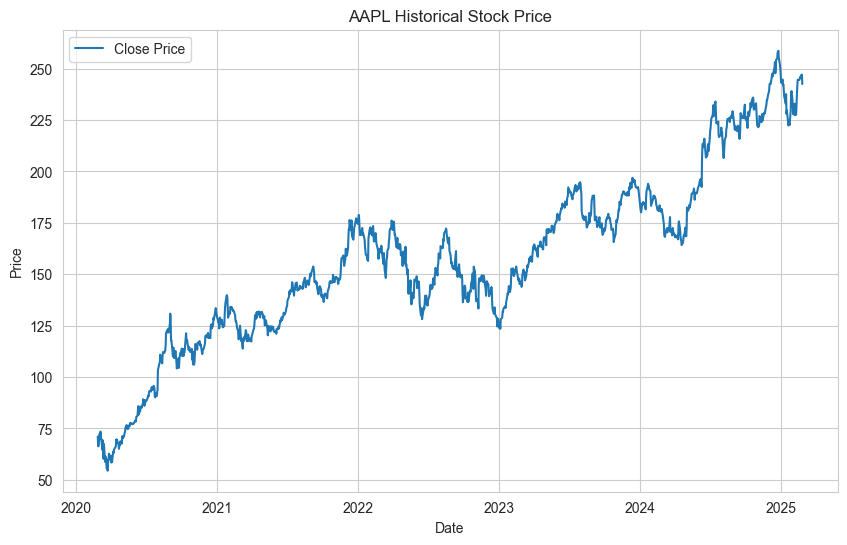

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(stock_data['Close'], label='Close Price')
plt.title(f"{ticker} Historical Stock Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

In [11]:
stock_data['LogReturn'] = np.log(stock_data['Close'] / stock_data['Close'].shift(1))
stock_data.dropna(inplace=True)

In [12]:
stock_data['LogReturn'] *= 100

In [13]:
garch_model = arch_model(stock_data['LogReturn'], vol='Garch', p=1, q=1)
garch_model_fit = garch_model.fit(disp='off')

In [14]:
print(garch_model_fit.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:              LogReturn   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2493.91
Distribution:                  Normal   AIC:                           4995.82
Method:            Maximum Likelihood   BIC:                           5016.37
                                        No. Observations:                 1257
Date:                Wed, Feb 26 2025   Df Residuals:                     1256
Time:                        10:51:23   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1248  4.899e-02      2.548  1.084e-02 [2.880e-0

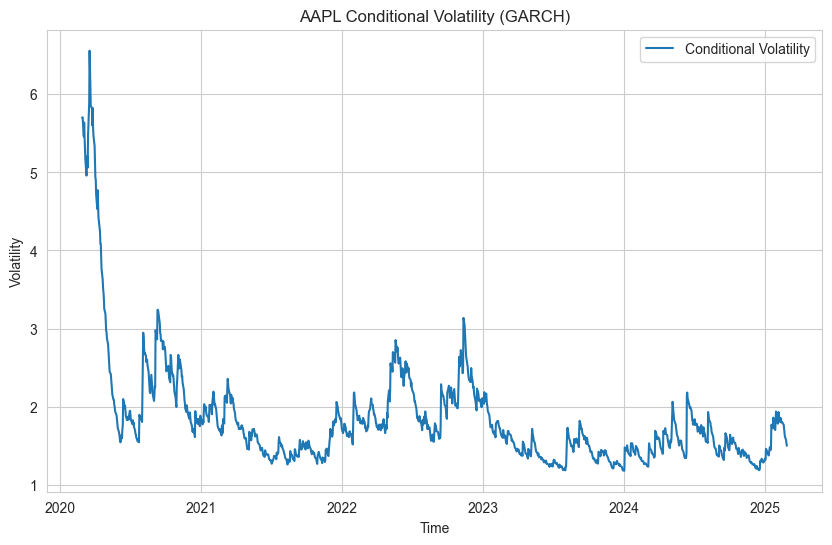

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(garch_model_fit.conditional_volatility, label='Conditional Volatility')
plt.title(f"{ticker} Conditional Volatility (GARCH)")
plt.xlabel("Time")
plt.ylabel("Volatility")
plt.legend()
plt.show()

In [16]:
underlying_price = stock_data['Close'].iloc[-1]
risk_free_rate = interest_rate / 100

In [17]:
volModel = VolatilityModel(options_chain_df=options, underlying_price=underlying_price, risk_free_rate=risk_free_rate)
historical_volatility = garch_model_fit.conditional_volatility

In [18]:
options['ImpliedVolatility'] = options.apply(
    lambda row: volModel.calculate_implied_volatility(
        option_price=row['mark'],
        strike=row['strikePrice'],
        expiration_days=row['daysToExpiration'],
        option_type=row['putCall'],  # 'CALL' or 'PUT'
    ),
    axis=1
)

In [19]:
# Display the first few rows of the options chain with implied volatilities
print("Options Chain with Implied Volatilities:")
print(options.head())

Options Chain with Implied Volatilities:
   strikePrice expirationDate putCall   bid   ask  mark  volatility  delta  \
0        242.5     2025-02-28    CALL  2.35  2.38  2.37      29.926  0.511   
1        245.0     2025-02-28    CALL  1.24  1.26  1.25      29.246  0.339   
2        247.5     2025-02-28    CALL  0.59  0.60  0.60      28.933  0.195   
3        250.0     2025-02-28    CALL  0.25  0.26  0.26      29.010  0.098   
4        252.5     2025-02-28    CALL  0.11  0.12  0.12      30.090  0.048   

   gamma  theta   vega    rho  openInterest  timeValue  \
0  0.069 -0.591  0.077  0.008          2655       2.38   
1  0.065 -0.508  0.071  0.005         19602       1.25   
2  0.049 -0.342  0.053  0.003         13896       0.57   
3  0.031 -0.185  0.033  0.001         23519       0.26   
4  0.017 -0.095  0.019  0.001         27494       0.11   

   theoreticalOptionValue  ImpliedVolatility  daysToExpiration  inTheMoney  
0                   2.344           0.336341                 2  

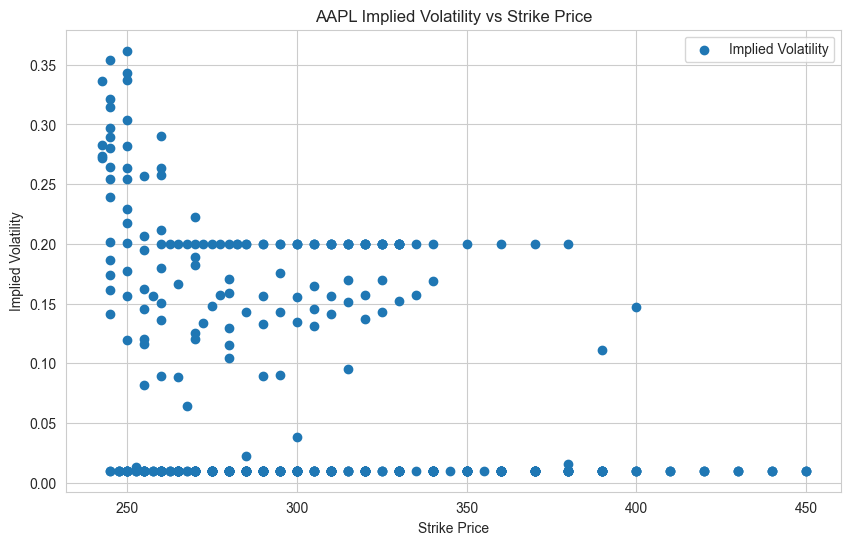

In [20]:
# Plot implied volatility vs strike price
plt.figure(figsize=(10, 6))
plt.scatter(options['strikePrice'], options['ImpliedVolatility'], label='Implied Volatility')
plt.title(f"{ticker} Implied Volatility vs Strike Price")
plt.xlabel("Strike Price")
plt.ylabel("Implied Volatility")
plt.legend()
plt.show()

In [21]:
strikes = options['strikePrice'].values
expirations = options['daysToExpiration'].values
implied_vols = options['ImpliedVolatility'].values

In [22]:
grid_strikes, grid_expirations = np.meshgrid(
    np.linspace(strikes.min(), strikes.max(), 100),
    np.linspace(expirations.min(), expirations.max(), 100)
)

In [23]:
# Add small noise to strikes and expirations
noise_level = 1e-5  # Adjust this value as needed
strikes = options['strikePrice'].values + np.random.normal(0, noise_level, size=len(options))
expirations = options['daysToExpiration'].values + np.random.normal(0, noise_level, size=len(options))
implied_vols = options['ImpliedVolatility'].values

# Create a grid for interpolation
grid_strikes, grid_expirations = np.meshgrid(
    np.linspace(strikes.min(), strikes.max(), 100),
    np.linspace(expirations.min(), expirations.max(), 100)
)

# Interpolate using cubic spline
volatility_surface = griddata(
    (strikes, expirations), implied_vols,
    (grid_strikes, grid_expirations), method='cubic'
)

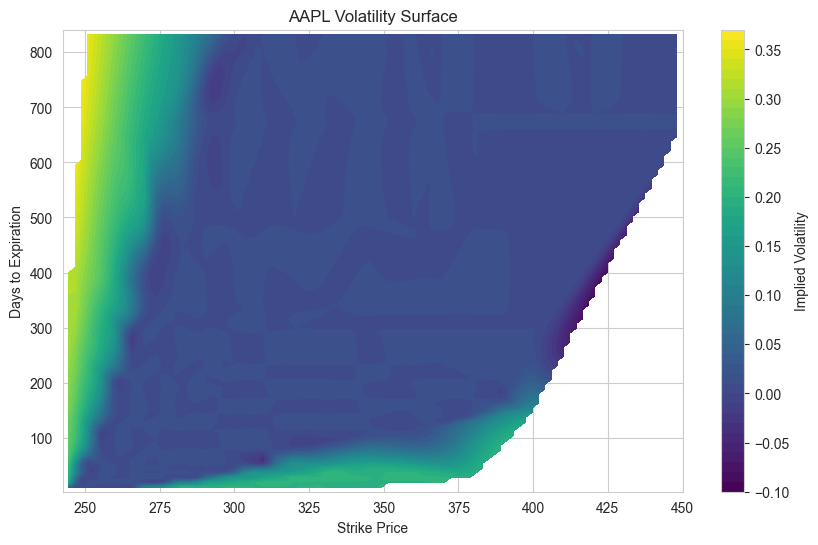

In [24]:
plt.figure(figsize=(10, 6))
plt.contourf(grid_strikes, grid_expirations, volatility_surface, levels=50, cmap='viridis')
plt.colorbar(label='Implied Volatility')
plt.title(f"{ticker} Volatility Surface")
plt.xlabel("Strike Price")
plt.ylabel("Days to Expiration")
plt.show()

In [25]:
underlying_price = stock_data['Close'].iloc[-1]
options['Moneyness'] = underlying_price[0] / options['strikePrice']
options['TimeToExpiration'] = options['daysToExpiration'] / 365
options['RiskFreeRate'] = interest_rate / 100
options['HistoricalVolatility'] = garch_model_fit.conditional_volatility[-1] / 100

In [26]:
print("Options Chain with Features:")
print(options.head())

Options Chain with Features:
   strikePrice expirationDate putCall   bid   ask  mark  volatility  delta  \
0        242.5     2025-02-28    CALL  2.35  2.38  2.37      29.926  0.511   
1        245.0     2025-02-28    CALL  1.24  1.26  1.25      29.246  0.339   
2        247.5     2025-02-28    CALL  0.59  0.60  0.60      28.933  0.195   
3        250.0     2025-02-28    CALL  0.25  0.26  0.26      29.010  0.098   
4        252.5     2025-02-28    CALL  0.11  0.12  0.12      30.090  0.048   

   gamma  theta  ...  openInterest  timeValue  theoreticalOptionValue  \
0  0.069 -0.591  ...          2655       2.38                   2.344   
1  0.065 -0.508  ...         19602       1.25                   1.255   
2  0.049 -0.342  ...         13896       0.57                   0.595   
3  0.031 -0.185  ...         23519       0.26                   0.255   
4  0.017 -0.095  ...         27494       0.11                   0.115   

   ImpliedVolatility  daysToExpiration  inTheMoney  Moneyness  

### Train the XGBoost model

In [27]:
pricing_model = PricingModel()
pricing_model.train_xgboost_model(options)

Validation Mean Squared Error: 0.0007727511541016114


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [28]:
predicted_chain = pricing_model.predict_option_chain(
    stock_price=stock_data['Close'].iloc[-1],
    options_chain=options,
    interest_rate=interest_rate,
    historical_volatility=historical_volatility.iloc[-1]
)

In [29]:
print("Predicted Option Chain:")
print(predicted_chain.head())

Predicted Option Chain:
   strikePrice expirationDate putCall   bid   ask  \
0        242.5     2025-02-28    CALL  2.35  2.38   
1        245.0     2025-02-28    CALL  1.24  1.26   
2        247.5     2025-02-28    CALL  0.59  0.60   
3        250.0     2025-02-28    CALL  0.25  0.26   
4        252.5     2025-02-28    CALL  0.11  0.12   

                                                mark  volatility  \
0  Ticker
AAPL    2.447161
Name: 2025-02-26 00:00...    0.336341   
1  Ticker
AAPL    2.834424e-43
Name: 2025-02-26 0...    0.010000   
2  Ticker
AAPL    1.077854e-164
Name: 2025-02-26 ...    0.010000   
3  Ticker
AAPL    0.0
Name: 2025-02-26 00:00:00, ...    0.010000   
4  Ticker
AAPL    0.0
Name: 2025-02-26 00:00:00, ...    0.013230   

           delta                                              gamma  \
0   5.100641e-01  Ticker
AAPL    0.06605
Name: 2025-02-26 00:00:...   
1   2.142986e-41  Ticker
AAPL    1.611428e-39
Name: 2025-02-26 0...   
2  1.633985e-162  Ticker
AAPL    2.

### Trading Signals

In [30]:
signal_generator = SignalGenerator(threshold=0.05)
signals = signal_generator.generate_trading_signals(predicted_chain)

In [31]:
print("\nTrading Signals:")
print(signal_generator.format_output(signals))


Trading Signals:
Option: CALL 242.5 Expiring on 2025-02-28
Market Price: $2.45, Predicted Price: $2.45, Difference: 0.00%
Signal: Hold
Greeks - Delta: 0.5101, Gamma: 0.0661, Theta: -0.5877, Vega: 0.0716, Rho: 0.0066
In The Money: False
--------------------------------------------------
Option: CALL 245.0 Expiring on 2025-02-28
Market Price: $0.00, Predicted Price: $0.00, Difference: 0.00%
Signal: Hold
Greeks - Delta: 0.0000, Gamma: 0.0000, Theta: -0.0000, Vega: 0.0000, Rho: 0.0000
In The Money: False
--------------------------------------------------
Option: CALL 247.5 Expiring on 2025-02-28
Market Price: $0.00, Predicted Price: $0.00, Difference: 0.00%
Signal: Hold
Greeks - Delta: 0.0000, Gamma: 0.0000, Theta: -0.0000, Vega: 0.0000, Rho: 0.0000
In The Money: False
--------------------------------------------------
Option: CALL 250.0 Expiring on 2025-02-28
Market Price: $0.00, Predicted Price: $0.00, Difference: inf%
Signal: Sell
Greeks - Delta: 0.0000, Gamma: 0.0000, Theta: 0.0000, V

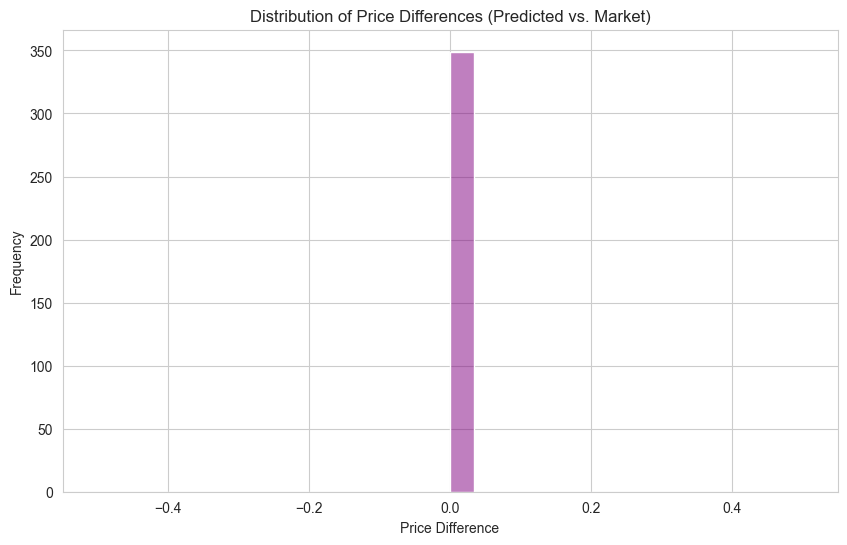

In [32]:
plt.figure(figsize=(10, 6))
sns.histplot(signals['priceDifference'], bins=30, kde=True, color="purple")
plt.title("Distribution of Price Differences (Predicted vs. Market)")
plt.xlabel("Price Difference")
plt.ylabel("Frequency")
plt.show()

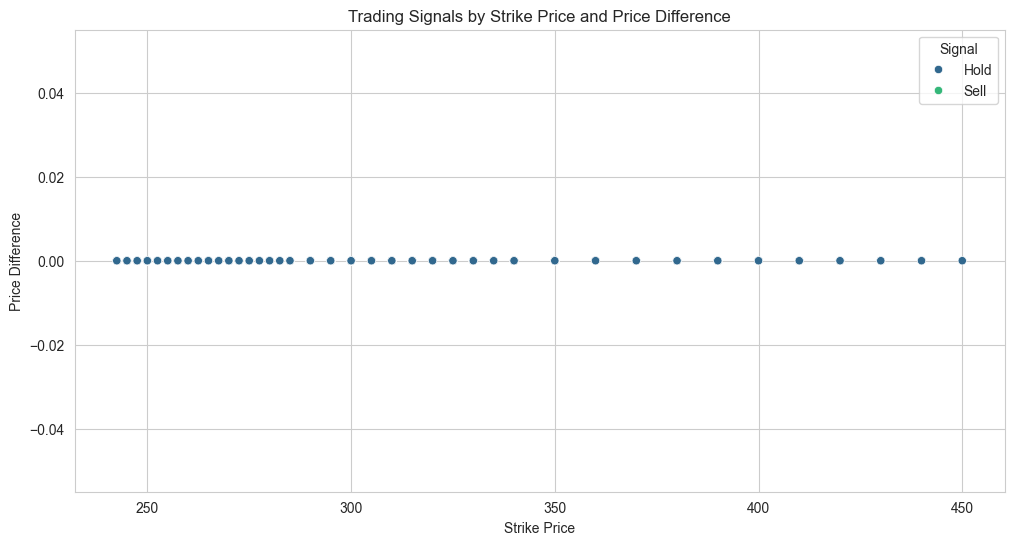

In [33]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x="strikePrice", y="priceDifference", hue="signal", data=signals, palette="viridis")
plt.title("Trading Signals by Strike Price and Price Difference")
plt.xlabel("Strike Price")
plt.ylabel("Price Difference")
plt.legend(title="Signal")
plt.show()